---
# Mega script
---

In [367]:
%load_ext autoreload
%autoreload 2

import tools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from confusion_matrix import confusion_matrix
from sklearn.metrics import confusion_matrix as cf
from sklearn.feature_selection import SequentialFeatureSelector

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "cmr"
# })

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
config = {
    "standardize" : True,
    "lda_reduce" : 4,
    "classifier" : "qda",
    "keep_features" : 7,
    "drop_8_18" : False,
    "direction" : "backward",
    "frac_sample" : 0.4
}

svm_args = {
    'C':1000,
    'gamma':0.01, 
    'decision_function_shape':"ovo",
}

In [369]:
# Load data sets
trn = tools.dataloader("../TrainingData/neodata/soltani_14d_nonoise_1200.csv",'target')
vld = tools.dataloader("../ValidationData/neodata/soltani_14d_nonoise_1200.csv",'target')
tst = tools.dataloader("../TestData/neodata/soltani_14d_nonoise_100.csv",'target')

----
## Standardize data

In [370]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

trn_std = trn.apply(standardizer.fit_transform) if config["standardize"] else trn
vld_std = vld.apply(standardizer.transform)     if config["standardize"] else vld
tst_std = tst.apply(standardizer.transform)     if config["standardize"] else tst

In [371]:
features.tolist()

['T0', 'Tc', 'Tdis', 'Tret', 'Tsh', 'Tsup', 'Tset']

In [372]:
trn_std.get(features).X

,T0,Tc,Tdis,Tret,Tsh,Tsup,Tset
0,-1.068557,0.057429,1.000287,-0.641558,0.460607,-0.689964,-1.248179
1,0.818121,-0.701974,-1.227919,0.050529,-1.042854,0.248801,1.128362
2,0.341785,-1.050073,-1.093017,-0.404384,-1.314898,-0.139321,0.138136
3,0.742188,-0.489872,-1.019834,0.104161,-0.857029,0.248736,1.128362
4,-0.363677,0.555684,0.670913,-0.047992,0.571077,-0.142810,0.138136
...,...,...,...,...,...,...,...
25195,0.758678,1.333146,-0.299158,0.087546,-0.840322,0.246954,1.128362
25196,0.327663,0.060695,-0.627797,-0.402779,-1.188465,-0.143087,0.138136
25197,-0.414574,4.461616,2.382439,-0.077437,0.832363,-0.143704,0.138136
25198,-0.555301,0.216461,0.258145,-0.874116,-0.923578,-0.689423,-1.248179


----
## Classifier definitions

In [373]:
def classifier(classifier_select):
    if classifier_select == "qda":
        from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
        return QuadraticDiscriminantAnalysis()
        
    elif classifier_select == "lda":
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis()

    elif classifier_select == "svm":
        from sklearn import svm
        return svm.SVC( **svm_args )

----
## Feature selection

In [374]:
def feature_selection(clf,trn : tools.dataloader ,vld : tools.dataloader):

    summary = pd.DataFrame({'n_features':[],'score':[], 'features' : [], 'direction' : []})
    for n_features in range( 2, np.shape(trn.X.columns)[0] ):
        for direction in ["forward","backward"]:
            
            bw = SequentialFeatureSelector(clf, direction=direction, n_jobs=-1, n_features_to_select=n_features)
            bw.fit(trn.X, trn.y)

            features = trn.X.columns[bw.get_support()]

            score_clf = clf
            score_clf.fit(trn.get(features).X,trn.y)

            score = score_clf.score(vld.get(features).X,vld.y)
            summary = pd.concat([summary, pd.DataFrame({'n_features':n_features,'score':score,'features': features, 'direction': direction})], )
    
    return summary

# Caching of feature selection if classifier is unchanged
if (not 'summary' in globals()) or (not 'cached_config' in globals()):
    cached_config = config
    summary = feature_selection(classifier(config["classifier"]), trn_std.sample(frac=config["frac_sample"]) , vld_std.sample(frac=config["frac_sample"]))
elif 'cached_classifier' in globals():
    if (cached_config["classifier"] != config["classifier"]) or (cached_config["frac_sample"] != config["frac_sample"]) or (cached_config["standardize"] != config["standardize"]):
        cached_config = config
        summary = feature_selection(classifier(config["classifier"]), trn_std.sample(frac=config["frac_sample"]) , vld_std.sample(frac=config["frac_sample"]))

In [375]:
features = summary[(summary["n_features"] == config["keep_features"]) & (summary["direction"] == config["direction"])]["features"]
print(f"Keeping : { features.tolist() }") 

trn_drop = trn_std.get(features.tolist()) if config["keep_features"] else trn_std
vld_drop = vld_std.get(features.tolist()) if config["keep_features"] else vld_std
tst_drop = tst_std.get(features.tolist()) if config["keep_features"] else tst_std

Keeping : ['T0', 'Tc', 'Tdis', 'Tret', 'Tsh', 'Tsup', 'Tset']


----
## LDA dimensionality reduction

### Try all possibilities of LDA reduction

In [376]:
import lda

lda_accuracy = []
for dimensions in range(1,len(trn_drop.X.columns)):
    
    reducer = lda.reducer(trn_drop.X,trn_drop.y, dimensions, verbose = False)

    trn_red = trn_drop.apply(reducer.transform)
    vld_red = vld_drop.apply(reducer.transform)
    
    clf = classifier(config["classifier"])
    clf.fit(trn_red.X,trn_red.y)

    lda_accuracy.append( sum(clf.predict(vld_red.X) == vld_red.y)/len(vld_red.y) )

### Do actual reduction according to config

In [377]:
reducer = lda.reducer(trn_drop.X,trn_drop.y,config["lda_reduce"])

trn_red = trn_drop.apply(reducer.transform) if config["lda_reduce"] else trn_drop
tst_red = tst_drop.apply(reducer.transform) if config["lda_reduce"] else tst_drop
vld_red = vld_drop.apply(reducer.transform) if config["lda_reduce"] else vld_drop

Conditioning number of Sw : 139.91698721628686
Preserving 99.7% of variance


----
# Classification of feature selected data

In [378]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

# Train classifier
clf = classifier(config["classifier"])
clf.fit(trn_drop.X,trn_drop.y);

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot: title={'center': 'FS7-QDA of validation set : Accuracy 95.635%'}, xlabel='Predicted class', ylabel='True class'>)

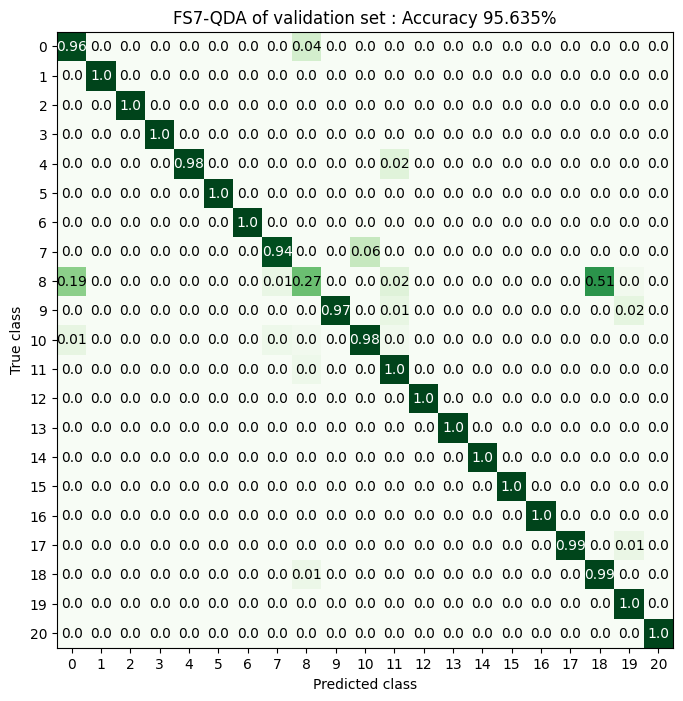

In [379]:
# Make predictions for the training set
y_hat_vld = clf.predict(vld_drop.X)

#plot the confusion matrix
conf_matrix_vld = cf(vld_drop.y,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    figsize = (8,8),
    title = f'{str_feature}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_classifier}-validation.pdf')

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot: title={'center': 'FS7-QDA of test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

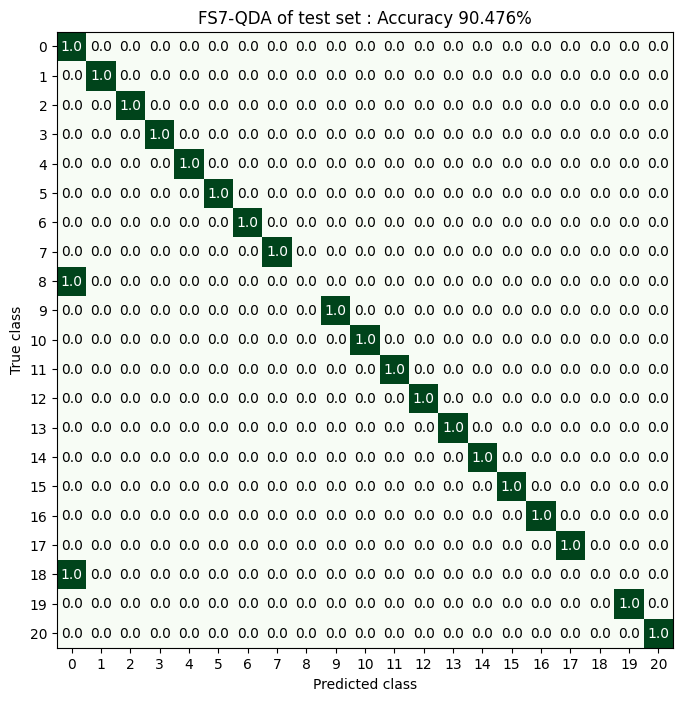

In [380]:
# Make predictions for the training set
y_hat_tst = clf.predict(tst_drop.X)

#plot the confusion matrix
conf_matrix_tst = cf(tst_drop.y,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    figsize = (8,8),
    title = f'{str_feature}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_classifier}-test.pdf')

----
# Classification on LDA-reduced data

In [381]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_lda = f"LDA{x}-" if (x:=config["lda_reduce"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

# Train classifier
clf = classifier(config["classifier"])
clf.fit(trn_red.X,trn_red.y);

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot: title={'center': 'FS7-LDA4-QDA of validation set : Accuracy 88.302%'}, xlabel='Predicted class', ylabel='True class'>)

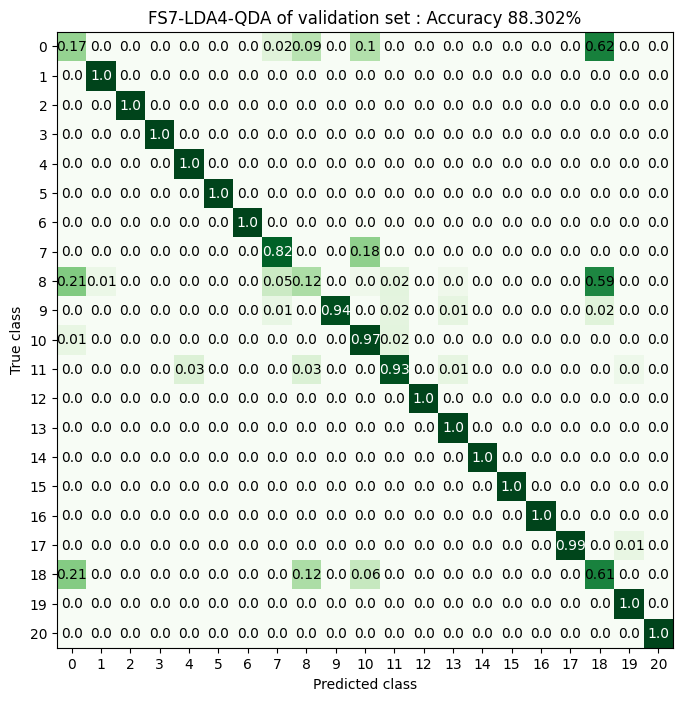

In [382]:
# Make predictions for the training set
y_hat_vld = clf.predict(vld_red.X)

#plot the confusion matrix
conf_matrix_vld = cf(vld_red.y,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    figsize = (8,8),
    title = f'{str_feature}{str_lda}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-validation.pdf')

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot: title={'center': 'FS7-LDA4-QDA of test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

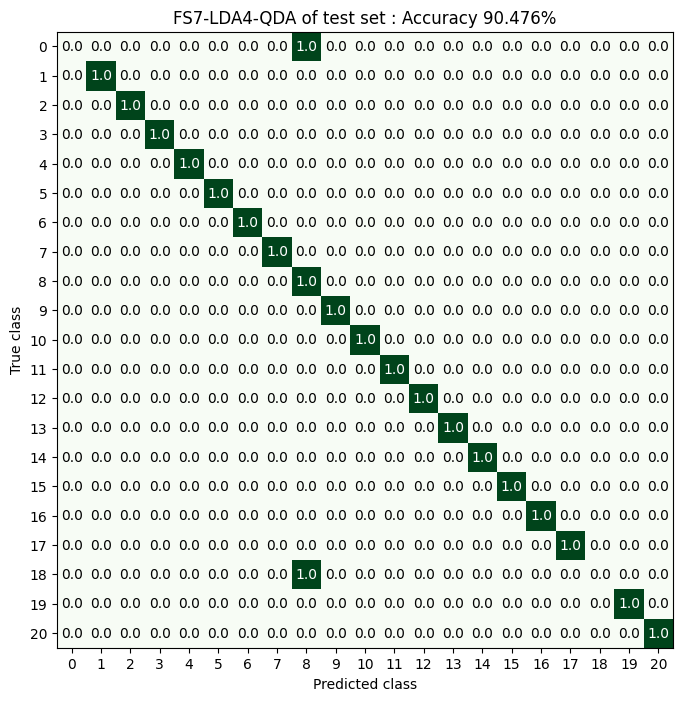

In [383]:
# Make predictions for the training set
y_hat_tst = clf.predict(tst_red.X)

#plot the confusion matrix
conf_matrix_tst = cf(tst_red.y,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    figsize = (8,8),
    title = f'{str_feature}{str_lda}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-test.pdf')

----
# Extra plots

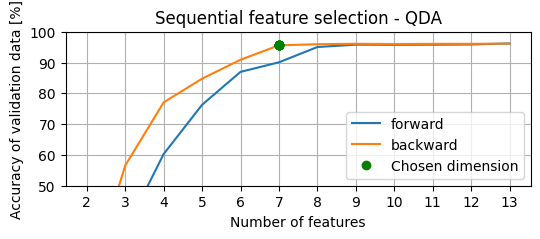

In [384]:
fig,axs = plt.subplots(figsize=(6,2))

# Plot feature selection
for j in ["forward","backward"]:
    plot_data = summary.loc[summary['direction'] == j]
    axs.plot(plot_data['n_features'],plot_data['score']*100, label = j)

feat = plot_data['n_features'][plot_data['n_features'] == config["keep_features"]]
data = plot_data['score'][plot_data['n_features'] == config["keep_features"]]*100
axs.plot(feat,data,'o',c="green",label = "Chosen dimension")
axs.set_ylabel('Accuracy of validation data [%]')
axs.set_xlabel('Number of features')
axs.set_ylim([50,100])
axs.set_title(f'Sequential feature selection - {config["classifier"].upper()}')
axs.grid(True)
axs.legend()
axs.set_xticks(range(2,14));


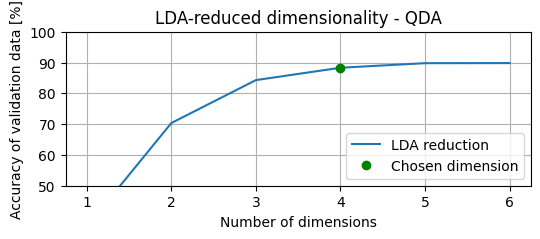

In [385]:
# Plot LDA reduction
fig,axs = plt.subplots(figsize=(6,2))
axs.plot(range(1,len(trn_drop.X.columns)),np.array(lda_accuracy)*100,label = "LDA reduction")
axs.plot(config["lda_reduce"],lda_accuracy[config["lda_reduce"]-1]*100,'o',c="green",label = "Chosen dimension")
axs.set_title(f'LDA-reduced dimensionality - {config["classifier"].upper()}')
axs.set_xticks(range(1,len(trn_drop.X.columns)))
axs.set_xlabel("Number of dimensions")
axs.set_ylabel("Accuracy of validation data [%]")
axs.set_ylim([50,100])
axs.legend()
axs.grid()